# Moulinec-Suquet as Newton-Krylov solver

In this tutorial, we will solve a linear elasticity problem using Moulinec-Suquet's Green's operator but recasted the Lippmann-Schwinger equation as a Newton-Krylov solver.

In [3]:
import jax

jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")

import jax.numpy as jnp
from jax import Array

import numpy as np
import equinox as eqx

import matplotlib.pyplot as plt

In [4]:
from xpektra import (
    SpectralSpace,
    TensorOperator,
    make_field,
)
from xpektra.projection_operator import MoulinecSuquetProjection
from xpektra.solvers.nonlinear import (  # noqa: E402
    conjugate_gradient_while,
    newton_krylov_solver,
)

Let us start by defining the RVE geometry. We will consider a 2D square RVE with a circular inclusion.

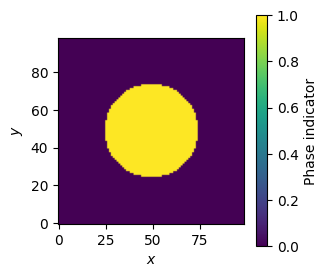

In [5]:
N = 99
ndim = 2
length = 1


# Create phase indicator (cylinder)
x = np.linspace(-0.5, 0.5, N)

if ndim == 3:
    Y, X, Z = np.meshgrid(x, x, x, indexing="ij")  # (N, N, N) grid
    phase = jnp.where(X**2 + Z**2 <= (0.2 / np.pi), 1.0, 0.0)  # 20% vol frac
else:
    X, Y = np.meshgrid(x, x, indexing="ij")  # (N, N) grid
    phase = jnp.where(X**2 + Y**2 <= (0.2 / np.pi), 1.0, 0.0)


plt.figure(figsize=(3, 3))
cb = plt.imshow(phase, origin="lower")
plt.colorbar(cb, label="Phase indicator")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

Based on the phase indicator, we can now define the material parameters. We will consider a linear elastic material with different properties in the inclusion and the matrix.

In [6]:
# Material parameters [grids of scalars, shape (N,N,N)]
lambda1, lambda2 = 10.0, 1000.0
mu1, mu2 = 0.25, 2.5
lambdas = lambda1 * (1.0 - phase) + lambda2 * phase
mu = mu1 * (1.0 - phase) + mu2 * phase

## Defining TensorOperator and SpectralSpace



In [7]:
tensor = TensorOperator(dim=ndim)
space = SpectralSpace(size=N, dim=ndim, length=length)

## Defining the constitutive law

In [8]:

@eqx.filter_jit
def _strain_energy(eps: Array, lambdas: Array, mu: Array) -> Array:
    eps_sym = 0.5 * (eps + tensor.trans(eps))
    energy = 0.5 * jnp.multiply(lambdas, tensor.trace(eps_sym) ** 2) + jnp.multiply(
        mu, tensor.trace(tensor.dot(eps_sym, eps_sym))
    )
    return energy.sum()



## Defining the reference material for Moulinec-Suquet projection

To define the reference material, we will use the average properties of the material. We make use of `jax.jacrev` to compute the stress tensor as a function of the strain tensor. This way we do not need to store the reference material tensor in memory.

In [9]:
# Use average properties for the reference material
lambda0 = (lambda1 + lambda2) / 2.0
mu0 = (mu1 + mu2) / 2.0

material_energy = eqx.Partial(_strain_energy, lambdas=lambdas, mu=mu)
reference_energy = eqx.Partial(_strain_energy, lambdas=lambda0, mu=mu0)

compute_stress = jax.jacrev(material_energy)
compute_reference_stress = jax.jacrev(reference_energy)

To check the correctness of our reference material, we can compare the stress computed using the reference material tensor with the stress computed using the average properties.

In [10]:
i = jnp.eye(ndim)
I = make_field(dim=ndim, N=N, rank=2) + i  # Add i to broadcast

I4 = jnp.einsum("il,jk->ijkl", i, i)
I4rt = jnp.einsum("ik,jl->ijkl", i, i)
I4s = (I4 + I4rt) / 2.0
II = jnp.einsum("...ij,...kl->...ijkl", I, I)

# Build the constant C0 reference tensor [shape (3,3,3,3)]
C0 = lambda0 * II + 2.0 * mu0 * I4s

assert np.allclose(tensor.ddot(C0, I), compute_reference_stress(I)), "Reference stress computation is incorrect"

We can now define the Moulinec-Suquet projection operator.

In [11]:

Ghat = MoulinecSuquetProjection(
    space=space, lambda0=lambda0, mu0=mu0
).compute_operator()

## Defining the residual and Jacobian

In [12]:
class Residual(eqx.Module):
    """A callable module that computes the residual vector."""

    Ghat: Array
    space: SpectralSpace = eqx.field(static=True)
    tensor_op: TensorOperator = eqx.field(static=True)
    dofs_shape: tuple = eqx.field(static=True)

    # We can even pre-define the stress function if it's always the same
    # For this example, we'll keep your original `compute_stress` function
    # available in the global scope.

    @eqx.filter_jit
    def __call__(self, eps_flat: Array, eps_macro: Array) -> Array:
        """
        This makes instances of this class behave like a function.
        It takes only the flattened vector of unknowns, as required by the solver.
        """
        eps = eps_flat.reshape(self.dofs_shape)
        sigma = compute_stress(eps) 
        sigma0 = compute_reference_stress(eps) 
        tau = sigma - sigma0
        eps_fluc = self.space.ifft(self.tensor_op.ddot(self.Ghat, self.space.fft(tau)))

        residual_field = eps - eps_macro + jnp.real(eps_fluc)

        return residual_field.reshape(-1)


class Jacobian(eqx.Module):
    """A callable module that represents the Jacobian operator (tangent)."""

    Ghat: Array
    space: SpectralSpace = eqx.field(static=True)
    tensor_op: TensorOperator = eqx.field(static=True)
    dofs_shape: tuple = eqx.field(static=True)

    @eqx.filter_jit
    def __call__(self, deps_flat: Array) -> Array:
        """
        The Jacobian is a linear operator, so its __call__ method
        represents the Jacobian-vector product.
        """

        deps = deps_flat.reshape(self.dofs_shape)

        dsigma = compute_stress(deps)
        dsigma0 = compute_reference_stress(deps) 
        dtau = dsigma - dsigma0
        jvp_field = self.space.ifft(
            self.tensor_op.ddot(self.Ghat, self.space.fft(dtau))
        )
        jvp_field = jnp.real(jvp_field) + deps
        return jvp_field.reshape(-1)



In [13]:
applied_strains = jnp.linspace(0, 1e-2, num=5)

eps = make_field(dim=2, N=N, rank=2)
deps = make_field(dim=2, N=N, rank=2)
eps_macro = make_field(dim=2, N=N, rank=2)

residual_fn = Residual(Ghat=Ghat, space=space, tensor_op=tensor, dofs_shape=eps.shape)
jacobian_fn = Jacobian(Ghat=Ghat, space=space, tensor_op=tensor, dofs_shape=eps.shape)


for inc, eps_avg in enumerate(applied_strains):
    # solving for elasticity
    eps_macro[:, :, 0, 0] = eps_avg
    eps_macro[:, :, 1, 1] = eps_avg

    residual_partial = eqx.Partial(residual_fn, eps_macro=eps_macro)

    b = -residual_partial(eps)
    # eps = eps + deps

    final_state = newton_krylov_solver(
        state=(deps, b, eps),
        gradient=residual_partial,
        jacobian=jacobian_fn,
        tol=1e-8,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-8,
        krylov_max_iter=20,
    )
    eps = final_state[2]

sig = compute_stress(final_state[2])

Converged, Residual value : 0.0
CG error = 0.12251249999999
CG error = 0.74556223960786
CG error = 3.62552279148538
CG error = 0.00000000000267
CG error = 0.00000000000001
CG error = 0.00000000000000
Converged, Residual value : 7.317107424141361e-09
CG error = 0.12251249996303
CG error = 0.74556223900889
CG error = 3.62552279079709
CG error = 0.00000000000267
CG error = 0.00000000000001
CG error = 0.00000000000000
Converged, Residual value : 7.317901764621601e-09
CG error = 0.12251249996308
CG error = 0.74556223900993
CG error = 3.62552279079223
CG error = 0.00000000000267
CG error = 0.00000000000001
CG error = 0.00000000000000
Converged, Residual value : 7.317898143372271e-09
CG error = 0.12251249996308
CG error = 0.74556223900993
CG error = 3.62552279079213
CG error = 0.00000000000267
CG error = 0.00000000000001
CG error = 0.00000000000000
Converged, Residual value : 7.317906235777618e-09


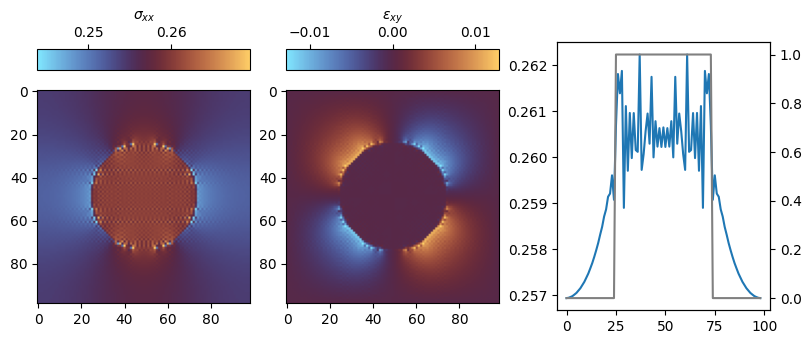

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3), layout="constrained")
cb1 = ax1.imshow(sig.at[:, :, 0, 0].get(), cmap="managua_r")

divider = make_axes_locatable(ax1)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(
    cb1, cax=cax, label=r"$\sigma_{xx}$", orientation="horizontal", location="top"
)

cb2 = ax2.imshow(eps.at[:, :, 0, 1].get(), cmap="managua_r")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(
    cb2, cax=cax, label=r"$\varepsilon_{xy}$", orientation="horizontal", location="top"
)

ax3.plot(sig.at[:, :, 0, 0].get()[:, int(N / 2)])
ax_twin = ax3.twinx()
ax_twin.plot(phase[int(N / 2), :], color="gray")
plt.show()